From Rowan Gaffney https://gist.github.com/rmg55/b144cb273d9ccfdf979e9843fdf5e651

In [1]:
from satsearch import Search
import intake
import stackstac, os, requests
from netrc import netrc
from subprocess import Popen
from getpass import getpass
import rasterio
from distributed import LocalCluster,Client
import datetime
import dask.array as dask_array
import dask
import dask.diagnostics

#from utils import DevNullStore,DiagnosticTimer,total_nthreads,total_ncores,total_workers,get_chunksize

import geopandas as gpd
import rioxarray
import numpy as np
import xarray as xr


In [2]:
def median(array, dim, keep_attrs=False, skipna=True, **kwargs):
    """ Runs a median on an dask-backed xarray.
    
    This function does not scale!
    It will rechunk along the given dimension, so make sure 
    your other chunk sizes are small enough that it 
    will fit into memory.
    
    :param DataArray array: An xarray.DataArray wrapping a dask array
    :param dim str: The name of the dim in array to calculate the median
    """
    if type(array) is xr.Dataset:
        return array.apply(median, dim=dim, keep_attrs=keep_attrs, **kwargs)
    
    if not hasattr(array.data, 'dask'):
        return array.median(dim, keep_attrs=keep_attrs, **kwargs)
    
    array = array.chunk({dim:-1})
    axis = array.dims.index(dim)
    median_func = np.nanmedian if skipna else np.median
    blocks = dask.array.map_blocks(median_func, array.data, dtype=array.dtype, drop_axis=axis, axis=axis, **kwargs)
    
    new_coords={k: v for k, v in array.coords.items() if k != dim and dim not in v.dims}
    new_dims = tuple(d for d in array.dims if d != dim)
    new_attrs = array.attrs if keep_attrs else None
    
    return xr.DataArray(blocks, coords=new_coords, dims=new_dims, attrs=new_attrs)


In [3]:
import os
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
                   AWS_NO_SIGN_REQUEST='YES',
                   GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
                   GDAL_SWATH_SIZE='200000000',
                   VSI_CURL_CACHE_SIZE='200000000',
                   GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                   GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))


os.environ.update(env)
    
# dask.config.set({'distributed.dashboard.link':'/proxy/{port}/status'})
# cluster = LocalCluster(threads_per_worker=1)
# cl = Client(cluster)
# cl

In [4]:
from satsearch import Search
def get_STAC_items(url, collection, dates, bbox):
    results = Search.search(url=url,
                        collections=collection, 
                        datetime=dates,
                        bbox=bbox)

    return(results)

In [5]:
data = 'hls'
if data == 'hls':
    #Setup NASA Credentials
    urs = 'urs.earthdata.nasa.gov'    # Earthdata URL to call for authentication
    prompts = ['Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
               'Enter NASA Earthdata Login Password: ']
    try:
        netrcDir = os.path.expanduser(r'C:\users\rscott\.netrc')
        #netrcDir = os.path.expanduser("~/.netrc")
        netrc(netrcDir).authenticators(urs)[0]
        del netrcDir

    # Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
    except FileNotFoundError:
        if 1 == 2:
            homeDir = os.path.expanduser("~")
            Popen('touch {0}.netrc | chmod og-rw {0}.netrc | echo machine {1} >> {0}.netrc'.format(homeDir + os.sep, urs), shell=True)
            Popen('echo login {} >> {}.netrc'.format(getpass(prompt=prompts[0]), homeDir + os.sep), shell=True)
            Popen('echo password {} >> {}.netrc'.format(getpass(prompt=prompts[1]), homeDir + os.sep), shell=True)
            del homeDir, urs, prompts

In [6]:
url = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD' 
collection = ['HLSS30.v1.5']#'C1711924822-LPCLOUD' #HLS
bbox = [-53.0172669999999968,-9.5331669999999988,-48.4956669999999974,-3.1035670000000000]    
bbox = [-53.0232820986343754,-8.1236837545427090, -49.4688521093868800,-4.8677173521785928] #carra grav
dates = '2013-01-01/2021-03-01'

limit = 500

#stac_hls = intake.open_stac_catalog(f'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections?limit={limit}')
carajas_grav_bounds = [-5407163.8851959239691496,-1289165.8399838600307703, -4627918.5439387122169137,-372068.2382511437172070]

from satsearch import Search
stac_items = Search(url='https://cmr.earthdata.nasa.gov/stac/LPCLOUD',
                 collections=['HLSL30.v1.5'], 
                 bbox = '-53.0172669999999968,-9.5331669999999988,-48.4956669999999974,-3.1035670000000000' ,
                 datetime='2016-04-23/2021-04-23', 
                ).items()

#print(stac_items.found())

#, assets=['B8A', 'B08', 'B09', 'B04', 'B12', 'B02', 'B06', 'B11', 'B07', 'B05', 'B03', 'Fmask', 'B01', 'B10']

stack = stackstac.stack(stac_items, epsg=6933, resolution=30, resampling=1, assets=['B8A', 'B08', 'B09', 'B04', 'B12', 'B02', 'B06', 'B11', 'B07', 'B05', 'B03', 'Fmask', 'B01', 'B10'])

stack


,Array,Chunk
Bytes,9.90 TiB,8.00 MiB
Shape,"(224, 11, 30957, 17846)","(1, 1, 1024, 1024)"
Count,1380398 Tasks,1374912 Chunks
Type,float64,numpy.ndarray


In [7]:
#filename = r'F:\Brazil\Brazil1.geojson'
filename = r'F:\Brazil\CarraGrav1.geojson'
filename = r'F:\Brazil\CarraGrav2.shp'
brazil = gpd.read_file(filename)

In [8]:
from shapely.geometry import mapping

cropped = stack.rio.clip(brazil.geometry.apply(mapping), crs=4326)
cropped

,Array,Chunk
Bytes,2.79 TiB,8.00 MiB
Shape,"(222, 11, 13733, 11428)","(1, 1, 1024, 1024)"
Count,3171391 Tasks,439560 Chunks
Type,float64,numpy.ndarray


In [17]:
cropped = stack ## try less tasks
cropped_clear = cropped[cropped["eo:cloud_cover"] < 50]
cropped_clear

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\stackstac\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))


,Array,Chunk
Bytes,815.00 GiB,8.00 MiB
Shape,"(18, 11, 30957, 17846)","(1, 1, 1024, 1024)"
Count,1478562 Tasks,110484 Chunks
Type,float64,numpy.ndarray


In [18]:
b02, b03 = cropped_clear.sel(band="B02"), cropped.sel(band="B03")
b02

,Array,Chunk
Bytes,74.09 GiB,8.00 MiB
Shape,"(18, 30957, 17846)","(1, 1024, 1024)"
Count,1488606 Tasks,10044 Chunks
Type,float64,numpy.ndarray


In [19]:
b02median = median(b02, dim="time")
b02median

<xarray.DataArray 'nanmedian-860f8b77befbe5fe07bfdb7f77bf75b2' (y: 30957, x: 17846)>
dask.array<nanmedian, shape=(30957, 17846), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
    band     <U5 'B02'
  * x        (x) float64 -5.184e+06 -5.184e+06 ... -4.648e+06 -4.648e+06
  * y        (y) float64 -3.457e+05 -3.457e+05 ... -1.274e+06 -1.274e+06

In [ ]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    #croppedNP = median(b02, dim="time").compute()
    croppedNP = b02median.compute()

[###########                             ] | 28% Completed |  3min  7.9s

In [75]:
boxlist = [croppedNP.x.min().values.item(), croppedNP.x.max().values.item(), croppedNP.y.min().values.item(), croppedNP.y.max().values.item()]
aspect = (   abs(croppedNP.x.max().values.item()) - abs(croppedNP.x.min().values.item())  )
aspect2 = aspect / (   abs(croppedNP.y.max().values.item()) - abs(croppedNP.y.min().values.item())  )


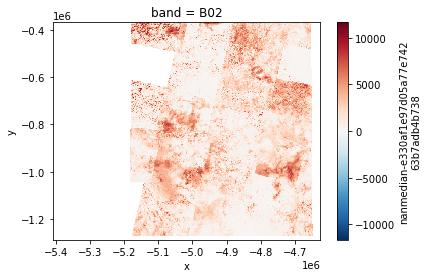

In [76]:
croppedNP.plot()

In [77]:
croppedNP.rio.write_crs('epsg:6933',inplace=True)
croppedNP.rio.to_raster(r'F:\Brazil\HLSCarraGravtest.tif')


In [7]:
stac_items[0].assets

{'Fmask': {'title': 'Download HLS.L30.T22LBQ.2021020T133759.v1.5.Fmask.tif',
  'href': 'https://lpdaac.earthdata.nasa.gov/lp-prod-protected/HLSL30.015/HLS.L30.T22LBQ.2021020T133759.v1.5.Fmask.tif'},
 'B09': {'title': 'Download HLS.L30.T22LBQ.2021020T133759.v1.5.B09.tif',
  'href': 'https://lpdaac.earthdata.nasa.gov/lp-prod-protected/HLSL30.015/HLS.L30.T22LBQ.2021020T133759.v1.5.B09.tif'},
 'SAA': {'title': 'Download HLS.L30.T22LBQ.2021020T133759.v1.5.SAA.tif',
  'href': 'https://lpdaac.earthdata.nasa.gov/lp-prod-protected/HLSL30.015/HLS.L30.T22LBQ.2021020T133759.v1.5.SAA.tif'},
 'B10': {'title': 'Download HLS.L30.T22LBQ.2021020T133759.v1.5.B10.tif',
  'href': 'https://lpdaac.earthdata.nasa.gov/lp-prod-protected/HLSL30.015/HLS.L30.T22LBQ.2021020T133759.v1.5.B10.tif'},
 'B07': {'title': 'Download HLS.L30.T22LBQ.2021020T133759.v1.5.B07.tif',
  'href': 'https://lpdaac.earthdata.nasa.gov/lp-prod-protected/HLSL30.015/HLS.L30.T22LBQ.2021020T133759.v1.5.B07.tif'},
 'B03': {'title': 'Download H